# Arquivo para teste de Regressão Múltipla e Outros Métodos em Inferência de Preços

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import seaborn as sns
import statsmodels.formula.api as sm

In [75]:
df = pd.read_csv('https://raw.githubusercontent.com/Lessalc/Inferencia/main/dados.csv', sep = ';')
df.drop(['DADO'], axis = 1, inplace=True)

In [81]:
df.head()

,AP,APANDAR,PA,COND,PU,PA_CATEG,PA_CATEG_DICT
0,114.0,4,ALTO,800.0,5000.00,2,2
1,110.0,2,BAIXO,935.0,4545.45,0,0
2,94.0,3,ALTO,520.0,5531.91,2,2
3,94.0,3,ALTO,520.0,5638.30,2,2
4,70.0,4,NORMAL,400.0,4500.00,1,1


In [82]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28 entries, 0 to 27
Data columns (total 7 columns):
AP               28 non-null float64
APANDAR          28 non-null int64
PA               28 non-null object
COND             28 non-null float64
PU               28 non-null float64
PA_CATEG         28 non-null int64
PA_CATEG_DICT    28 non-null int64
dtypes: float64(3), int64(3), object(1)
memory usage: 1.6+ KB


### Primeiro Parte: Tratar os tipos de dados.
- Vamos transformar 'AP' enm float 
- PA em categórico, para isso vamos criar uma função de classificação

In [78]:
def objeto_para_categorico(array, lista_objetos, lista_valor):
    new_arr = []
    for arr in array:
        posicao = lista_objetos.index(arr)
        new_arr.append(lista_valor[posicao])
    return new_arr

In [79]:
# Usamos uma função genérica, outra forma é usar um dicionário e a função map
df['PA_CATEG'] = objeto_para_categorico(df['PA'].values, ['BAIXO', 'NORMAL', 'ALTO'], [0,1,2]) 
# Mesmo resultado, de uma forma mais direta
categorias = dict({'BAIXO': 0, 'NORMAL': 1, 'ALTO': 2})
df['PA_CATEG_DICT'] = df['PA'].map(categorias)
df['AP'] = df['AP'].str.replace(',','.')
df['AP'] = pd.to_numeric(df['AP'], errors='coerce')

In [83]:
# Iremos criar outra coluna, LN de PU
df['LNPU'] = df['PU'].apply(np.log)

In [84]:
df.APANDAR.unique()

array([4, 2, 3, 6, 1], dtype=int64)

In [44]:
df.head()

,AP,APANDAR,PA,COND,PU,PA_CATEG,PA_CATEG_DICT,LNPU
0,114.0,4,ALTO,800.0,5000.00,2,2,8.517193
1,110.0,2,BAIXO,935.0,4545.45,0,0,8.421882
2,94.0,3,ALTO,520.0,5531.91,2,2,8.618288
3,94.0,3,ALTO,520.0,5638.30,2,2,8.637338
4,70.0,4,NORMAL,400.0,4500.00,1,1,8.411833


### Segunda Parte: Visualização dos Parâmetros

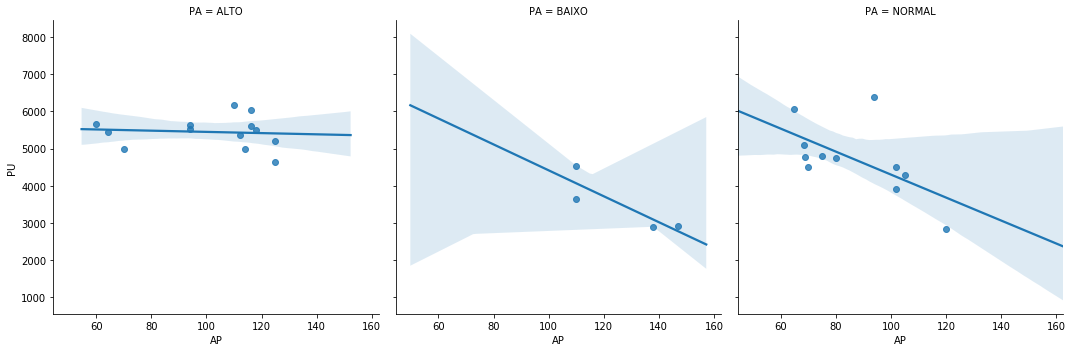

In [85]:
sns.lmplot(x = 'AP', y = 'PU', data = df, col='PA');

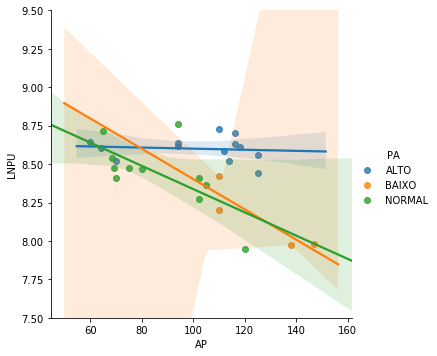

In [86]:
sns.lmplot(x = 'AP', y = 'LNPU', data = df, hue='PA')
plt.ylim(7.5,9.5);

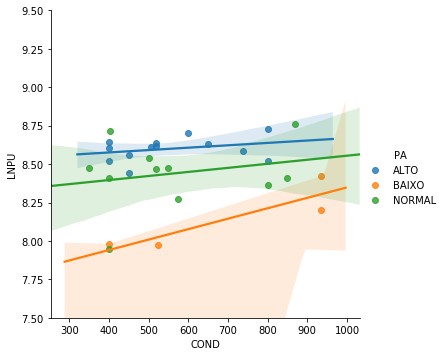

In [87]:
sns.lmplot(x = 'COND', y = 'LNPU', data = df, hue='PA')
plt.ylim(7.5,9.5);

### Terceira Parte: Criando o Modelo de Regressão
- Iremos gerar de duas formas diferentes

In [110]:
# Primeiro pelo sklearn
modelo1 = LinearRegression()
# Definir as colunas q usaremos no eixo X
X1 = df.loc[:,['AP','APANDAR','COND','PA_CATEG']]
# Definir quem será a variável Dependente, usaremos o LNPU
y1 = df.loc[:,'LNPU'].values.reshape(-1,1)
modelo1.fit(X1, y1)
modelo1.score(X1, y1)

0.8279971720746508

In [173]:
print('Interseção: ' + str(modelo1.intercept_))
for i in range(len(X1.columns)):
    print(X1.columns[i]+' - Inclinação: '+str(modelo1.coef_[0,i]))

Interseção: [8.9044765]
AP - Inclinação: -0.006493041569571779
APANDAR - Inclinação: -0.07839049042555746
COND - Inclinação: 0.0002909446376096218
PA_CATEG - Inclinação: 0.21173667648788388


In [174]:
# O modelo 2 é uma adaptação do modelo de R, temos mais informações diretamente do modelo
modelo2 = sm.ols(formula = 'LNPU ~ AP+APANDAR+COND+PA_CATEG', data = df)
modelo2 = modelo2.fit()
modelo2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   LNPU   R-squared:                       0.828
Model:                            OLS   Adj. R-squared:                  0.798
Method:                 Least Squares   F-statistic:                     27.68
Date:                Tue, 08 Dec 2020   Prob (F-statistic):           1.70e-08
Time:                        00:47:40   Log-Likelihood:                 27.552
No. Observations:                  28   AIC:                            -45.10
Df Residuals:                      23   BIC:                            -38.44
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      8.9045      0.187     47.733      0.000       8.519       9.290
AP            -0.0065      0.001     -6.263      0.000      -0.009      -0.004
APANDAR       -0.0784      0.022     -3.641      0.001      -0.123      -0.034
COND           0.0003      0.000      2.417      0.024    4.19e-05       0.001
PA_CATEG       0.2117      0.027      7.734      0.000       0.155       0.268
==============================================================================
Omnibus:                        0.689   Durbin-Watson:                   2.075
Prob(Omnibus):                  0.709   Jarque-Bera (JB):                0.764
Skew:                          -0.288   Prob(JB):                        0.682
Kurtosis:                       2.431   Cond. No.                     6.12e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 6.12e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

0.09979970085054023

In [119]:
modelo2.HC0_se

Intercept    0.165077
AP           0.001171
APANDAR      0.019844
COND         0.000107
PA_CATEG     0.022173
dtype: float64

### Quarta Parte: Gerar a tabela de Resíduos

In [125]:
residuos = pd.DataFrame()
residuos['LNPU_Observado'] = df['LNPU'].values
residuos['LNPU_Previstos'] = modelo1.predict(X1)
residuos['Residuo'] = residuos['LNPU_Observado'] - residuos['LNPU_Previstos']
residuos['Residuo_relativo'] = residuos['Residuo']/residuos['LNPU_Observado']* 100
# O erro do modelo não é explicitado. Para isso iremos calcular diretamente 
# Temos 4 variáveis independentes logo o grau de liberadade é 4 + 1
desv = np.std(residuos['Residuo'].values, ddof=5) # N + 1 graus de liberdade 
residuos['Residuo_padronizado'] = residuos['Residuo']/desv

In [ ]:
# Acrescentando os valores de PU agora
residuos['PU'] = df['PU'].values
residuos['VU'] = residuos['LNPU_Previstos'].apply(np.exp)
residuos['Residuo_estimat'] = residuos['PU'] - residuos['VU']
residuos['Residuo_estimat_relativo'] = residuos['Residuo_estimat']/residuos['PU']*100

In [149]:
residuos.head()

,LNPU_Observado,LNPU_Previstos,Residuo,Residuo_relativo,Residuo_padronizado,PU,VU,Residuo_estimat,Residuo_estimat_relativo
0,8.517193,8.506937,0.010256,0.120419,0.102769,5000.00,4948.980451,51.019549,1.020391
1,8.421882,8.305494,0.116388,1.381969,1.166214,4545.45,4046.041138,499.408862,10.987006
2,8.618288,8.633724,-0.015435,-0.179099,-0.154662,5531.91,5617.958880,-86.048880,-1.555500
3,8.637338,8.633724,0.003614,0.041844,0.036214,5638.30,5617.958880,20.341120,0.360767
4,8.411833,8.464516,-0.052683,-0.626302,-0.527892,4500.00,4743.431806,-243.431806,-5.409596


#### Gráfico de Aderência

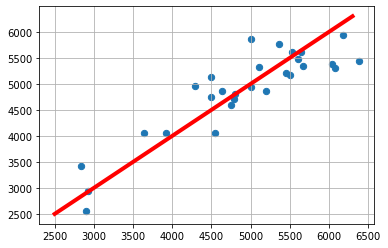

In [167]:
plt.scatter(residuos['PU'], residuos['VU'], s=40)
plt.plot(np.linspace(2500, 6300, 200), np.linspace(2500, 6300, 200), color = 'red', linewidth=4)
plt.grid()

In [ ]:
AP_Luciano <- 107
PA_Luciano <- 1 # Alto =1
APANDAR_Luciano <- 4
COND_Luciano <- 800

In [172]:
X_previsao = np.array([107, 4, 800, 3]).reshape(1, -1)
np.exp(modelo1.predict(X_previsao))

array([[6400.45801999]])

In [98]:
modelo1.coef_[0,1]

-0.07839049042555746

In [99]:
modelo1.coef_

array([[-0.00649304, -0.07839049,  0.00029094,  0.21173668]])

In [18]:
colunas = ['Id','Preco','Area','Dist','Coef_Aprov','ACL_DECL','Frente']

df = pd.read_csv('geo.txt', header = None, names = colunas)
df.drop(columns=['Id'], inplace=True)

In [19]:
df.head()

,Preco,Area,Dist,Coef_Aprov,ACL_DECL,Frente
0,25000,359.87,200,1.5,0.75,19.00
1,45000,353.12,500,3.0,1.00,12.18
2,45000,341.89,40,1.5,1.00,14.98
3,20000,435.99,200,1.5,0.75,12.18
4,25000,341.77,500,1.5,0.75,12.93


In [20]:
df.describe()

,Preco,Area,Dist,Coef_Aprov,ACL_DECL,Frente
count,54.000000,54.000000,54.000000,54.000000,54.000000,54.000000
mean,41296.296296,457.483519,284.259259,2.111111,0.930556,26.945185
std,16488.566227,261.527053,183.525247,0.743948,0.088177,17.570752
min,20000.000000,293.220000,40.000000,1.500000,0.750000,10.010000
25%,30000.000000,355.087500,200.000000,1.500000,0.900000,12.370000
50%,40000.000000,380.360000,200.000000,1.500000,1.000000,16.120000
75%,50000.000000,470.087500,500.000000,3.000000,1.000000,39.975000
max,120000.000000,2057.570000,650.000000,3.000000,1.000000,75.400000


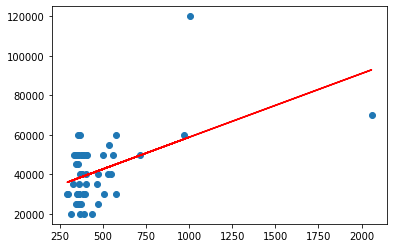

In [33]:
modelo = LinearRegression()
X = df.loc[:,'Area'].values.reshape(-1,1)
y = df.loc[:,'Preco'].values.reshape(-1,1)
modelo.fit(X, y)
plt.scatter(X, y)
plt.plot(X, modelo.predict(X), color = 'red')
plt.show()

In [36]:
# Score = R² 
modelo.score(X,y)

0.35018010801369304

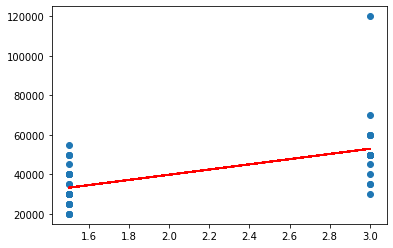

In [35]:
modelo = LinearRegression()
X = df.loc[:,'Coef_Aprov'].values.reshape(-1,1)
y = df.loc[:,'Preco'].values.reshape(-1,1)
modelo.fit(X, y)
plt.scatter(X, y)
plt.plot(X, modelo.predict(X), color = 'red')
plt.show()

In [37]:
modelo2 = sm.ols(formula = 'Preco ~ Area+Dist+Coef_Aprov+ACL_DECL+Frente', data = df)
modelo2 = modelo2.fit()
modelo2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Preco   R-squared:                       0.588
Model:                            OLS   Adj. R-squared:                  0.545
Method:                 Least Squares   F-statistic:                     13.72
Date:                Wed, 02 Dec 2020   Prob (F-statistic):           2.52e-08
Time:                        00:21:22   Log-Likelihood:                -576.52
No. Observations:                  54   AIC:                             1165.
Df Residuals:                      48   BIC:                             1177.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept  -3.903e+04   1.76e+04     -2.219      0.031   -7.44e+04   -3662.054
Area          16.6251      6.647      2.501      0.016       3.260      29.991
Dist          -3.9370      9.020     -0.436      0.664     -22.073      14.199
Coef_Aprov  8088.6255   2270.095      3.563      0.001    3524.294    1.27e+04
ACL_DECL    5.471e+04   1.83e+04      2.987      0.004    1.79e+04    9.15e+04
Frente       217.2639     95.773      2.269      0.028      24.700     409.828
==============================================================================
Omnibus:                       48.606   Durbin-Watson:                   2.139
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              251.369
Skew:                           2.326   Prob(JB):                     2.61e-55
Kurtosis:                      12.491   Cond. No.                     9.57e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 9.57e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [38]:
modelo1 = LinearRegression()
X1 = df.loc[:,['Area','Dist','Coef_Aprov','ACL_DECL','Frente']]
y1 = df.loc[:,'Preco'].values.reshape(-1,1)
modelo1.fit(X1, y1)
modelo1.score(X1,y1)

0.5883022243050506

In [39]:
valor_novo = np.array([260,180,0.75,1,30])

In [42]:
modelo1.predict(valor_novo.reshape(1,-1))

array([[31877.22091867]])

In [50]:
valor_novodf = pd.DataFrame(valor_novo.reshape(1,-1))
colunas2 = ['Area','Dist','Coef_Aprov','ACL_DECL','Frente']
valor_novodf.columns = colunas2
valor_novodf.head()

,Area,Dist,Coef_Aprov,ACL_DECL,Frente
0,260.0,180.0,0.75,1.0,30.0


In [51]:
modelo2.predict(valor_novodf)

0    31877.220919
dtype: float64

In [3]:
df = pd.read_csv('https://raw.githubusercontent.com/Lessalc/DataScience/master/dados.csv', sep = ';')

In [4]:
df.head()

,DADO,AP,APANDAR,PA,COND,PU
0,1,114,4,ALTO,800.0,5000.00
1,2,110,2,BAIXO,935.0,4545.45
2,3,94,3,ALTO,520.0,5531.91
3,4,94,3,ALTO,520.0,5638.30
4,5,70,4,NORMAL,400.0,4500.00
